In [1]:
%matplotlib inline

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model



Using TensorFlow backend.


# Load and prepare the data

In [2]:
X_load = np.load('../data/fake_data_realistic/X.npy')
Y_load = np.load('../data/fake_data_realistic/Y.npy')

n_hidden=100

In [3]:
print(np.sum(Y_load) / len(Y_load))

0.081236


In [4]:
res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

In [5]:
def save_model(model, save_dir='models'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    t = time.strftime("%Y%m%d-%H:%M:%S")
    path = os.path.join(save_dir, t+'.h5')  
    model.save(path)

    
def generator(X, y, batch_size, lookback):
    batch_features = np.zeros((batch_size, lookback, 1))
    batch_labels = np.zeros((batch_size, lookback, 2))
    batch_weights = np.zeros((batch_size, lookback))
    while True:
        for i in range(batch_size):
            index = np.random.randint(0, X.shape[0]-lookback)
            a = X[index:index+lookback]
            batch_features[i] = np.reshape(a, (a.shape[0], -1))
            batch_labels[i] = y[index:index+lookback]
            batch_weights[i] = y[index:index+lookback,0]*1. + y[index:index+lookback,1]*10
        yield batch_features, batch_labels, batch_weights

In [6]:
train_generator = generator(X_load[:90000], Y_load[:90000,:], 100, n_hidden)
validate_generator = generator(X_load[90000:], Y_load[90000:,:], 100, n_hidden)

In [7]:
n_dim = 1
input_shape = (None,n_dim)
batch_size = n_hidden

keras.backend.clear_session()
inputs = keras.layers.Input(shape=input_shape)

x = keras.layers.LSTM(100, activation='tanh', return_sequences=True)(inputs)
predictions = keras.layers.Dense(2, activation='softmax')(x)

model = keras.models.Model(inputs=inputs, outputs=predictions)
model.compile(loss=['categorical_crossentropy'],
              optimizer=keras.optimizers.Adam(lr=0.01),
              metrics=['accuracy'],
              sample_weight_mode='temporal')


print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 1)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         40800     
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           202       
Total params: 41,002
Trainable params: 41,002
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=20, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=100,
                              )

save_model(model)

Epoch 1/20
100/100 [==============================] - 17s 168ms/step - loss: 1.1617 - acc: 0.9120 - val_loss: 1.1947 - val_acc: 0.9172
Epoch 2/20
100/100 [==============================] - 17s 171ms/step - loss: 1.1575 - acc: 0.9242 - val_loss: 1.2036 - val_acc: 0.9178
Epoch 3/20
100/100 [==============================] - 15s 154ms/step - loss: 1.1828 - acc: 0.8553 - val_loss: 1.1857 - val_acc: 0.9189
Epoch 4/20
100/100 [==============================] - 17s 174ms/step - loss: 1.1704 - acc: 0.8588 - val_loss: 1.1905 - val_acc: 0.9185
Epoch 5/20
100/100 [==============================] - 18s 176ms/step - loss: 1.1423 - acc: 0.9147 - val_loss: 1.2087 - val_acc: 0.6600
Epoch 6/20
100/100 [==============================] - 18s 182ms/step - loss: 1.2005 - acc: 0.7410 - val_loss: 1.2056 - val_acc: 0.9151
Epoch 7/20
100/100 [==============================] - 16s 155ms/step - loss: 1.1697 - acc: 0.9039 - val_loss: 1.2018 - val_acc: 0.7965
Epoch 8/20
100/100 [==============================] - 1

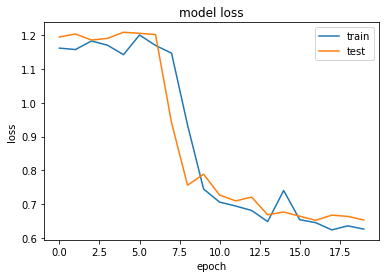

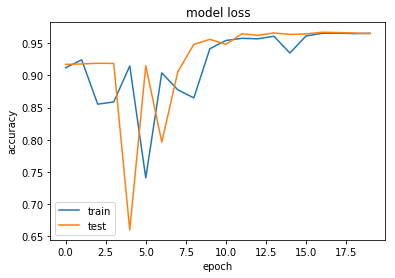

In [9]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [16]:
X, y, w = next(validate_generator)
res = model.predict(X)

In [17]:
save_dir = 'plots'

if not os.path.exists(save_dir):
        os.makedirs(save_dir)

# for i in range(res.shape[0]):
for i in range(50):
    path = os.path.join(save_dir, str(i)+'.pdf')  
    plt.figure()
    plt.plot(10.*X[i], lw=2, label='estimator')
    plt.plot(np.argmax(res[i], axis=1)-8, lw=2, label='estimator')
    plt.plot(np.argmax(y[i], axis=1)-8, lw=2, label='truth')
    plt.ylim(-10., 10.)
    plt.legend()
    plt.savefig(path)
    plt.close()